In [ ]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt

In [ ]:
# read dataset
dir_path = '/content/drive/MyDrive/dataset/dataset-collection'
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))
len(img_list)

2527

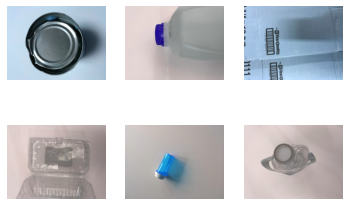

In [ ]:
# randomly show 6 images 
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = cv2.imread(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
#show image shape （the shapes of all the images in this dataset are same）
path = random.sample(img_list, 1)
img = cv2.imread(path[0])
img.shape

(384, 512, 3)

In [ ]:
# Define data Augmentation for training dataset
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

# Define data Augmentation for test dataset
test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

# Define training dataset
train_generator=train.flow_from_directory(dir_path, # path
                                          target_size=(300,300), # resize to smaller size
                                          batch_size=32,
                                          class_mode='categorical', # use one-hot encode labels
                                          subset='training')

# Define test dataset
test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

# get dictionary containing the mapping from class names to class indices
labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

In [ ]:
# writing the labels file
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
# Build CNN model
model=Sequential()

# Convolution and pooling layers
model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

# Classification layers/Fully connected layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

# Condition for model saving
filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        9

In [ ]:
# Compiling Model using categorical cross entropy loss function & Adam Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) 

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 4,
                              callbacks=callbacks_list) 
#test/validation acc
#33 epoch - 71%
#66 epoch - 76.3%
#93 epoch - 80.4%

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
71/71 [==============================] - 48s 651ms/step - loss: 1.5385 - acc: 0.3463 - val_loss: 1.4504 - val_acc: 0.3795

Epoch 00001: val_acc improved from 0.30357 to 0.37946, saving model to trained_model.h5
Epoch 2/100
71/71 [==============================] - 48s 646ms/step - loss: 1.4506 - acc: 0.4020 - val_loss: 1.4089 - val_acc: 0.3482

Epoch 00002: val_acc did not improve from 0.37946
Epoch 3/100
71/71 [==============================] - 48s 650ms/step - loss: 1.3875 - acc: 0.4260 - val_loss: 1.4011 - val_acc: 0.3839

Epoch 00003: val_acc improved from 0.37946 to 0.38393, saving model to trained_model.h5
Epoch 4/100
71/71 [==============================] - 48s 649ms/step - loss: 1.3784 - acc: 0.4412 - val_loss: 1.2928 - val_acc: 0.4509

Epoch 00004: val_acc improved from 0.38393 to 0.45089, saving model to trained_model.h5
Epoch 5/100
71/71 [==============================] - 48s 649ms/step - loss: 1.3330 - acc: 0.4572 - val_loss: 1.4557 - val_acc: 0.4107

Epoch 00005

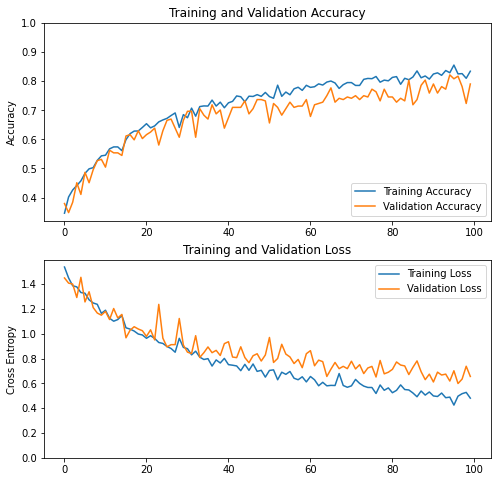

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# show training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# show training and validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Maximum Probability:  0.5216905
Classified: trash


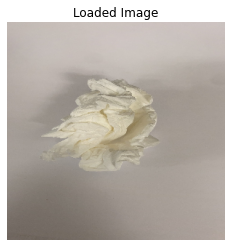

In [ ]:
from keras.preprocessing import image

# load a image to predict the class
img_path = '/content/drive/MyDrive/dataset/testtrash.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


-------------------Individual Probability--------------------------------

CARDBOARD : 0.54 %
GLASS : 15.26 %
METAL : 3.66 %
PAPER : 13.12 %
PLASTIC : 15.25 %
TRASH : 52.17 %


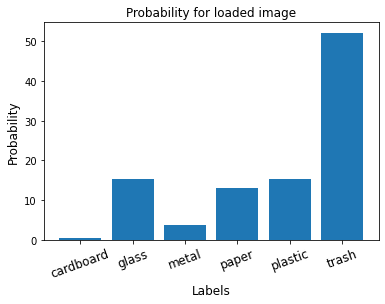

In [ ]:
# show individual probability for each class
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()